# Resources
Based on https://www.kaggle.com/code/vitouphy/phoneme-recognition-with-wav2vec2 with alterations for my own understanding of the steps.

Additional resources:
* https://huggingface.co/blog/fine-tune-xlsr-wav2vec2

In [1]:
!pip install datasets>=1.18.3
!pip install transformers==4.17.0
!pip install librosa
!pip install seaborn
!pip install jiwer
!pip install phonecodes
!pip install evaluate
!pip install TextGrid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 40.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires transformers>=4.33.1, but you have transformers 4.17.0 which is incompatible.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.17.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.8 MB/s eta 0:0

# Dataset handling

## load dataset

In [40]:
from datasets import load_dataset, Audio, Dataset, DatasetDict
from tqdm.auto import tqdm

import os, glob
import numpy as np
import pandas as pd
import torchaudio
import evaluate
from textgrid import TextGrid, IntervalTier
from phonecodes import phonecodes
from pathlib import Path


# disables weight and bias tracking. I think deprecated?
#os.environ["WANDB_DISABLED"] = "true"


Directory structure:
```text
l2-arctic-data/
└── speaker/
    └── speaker/
        ├── wav/          # Audio files (WAV)
        ├── transcript/   # Orthographic transcriptions (TXT)
        ├── textgrid/     # Phoneme transcriptions (TextGrid)
        └── annotation/   # Manual annotations (TextGrid)
```

In [3]:
# add input source from right menu first
ROOT= Path("/kaggle/input/l2-arctic-data")

In [4]:
# extract phonemes for reference
def phonemes_from_textgrid(tg_path: Path):
    tg = TextGrid.fromFile(str(tg_path))
    phone_tier = tg.getFirst("phones")
    labels = [interval.mark.strip() for interval in phone_tier if interval.mark.strip()]
    return " ".join(labels) if labels else None # join phonemes with spaces

Since we're focusing on one speaker L1 for the Irish model (i.e. English) we will mimic this kind of model for the 'skyline' and use one language (Spanish) for training and evaluation. The spanish speakers are in the following folders with gender noted as follows.
```text
EBVS	Spanish	M	
ERMS	Spanish	M	
MBMPS	Spanish	F	
NJS	Spanish	F
```

In [5]:
spanish_speakers = {
    'EBVS':'M',
    'ERMS':'M',
    'MBMPS':'F',
    'NJS':'F'
}

In [6]:
# made into yield function because they're neat
def iter_items(root):
    
    # iterate through speakers, include only spanish speakers
    speaker_dirs = sorted([
        speaker for speaker in root.iterdir() if speaker.is_dir() 
        and speaker.name in spanish_speakers.keys()
    ])
    
    for speaker_dir in speaker_dirs:
        # path of inner directory (speaker dirs are nested within dirs of same name.)
        inner = speaker_dir / speaker_dir.name

        # component directories
        wav_dir = inner / "wav" # sound files
        txt_dir = inner / "transcript" # orthographic representations
        tg_dir  = inner / "textgrid" # auto phone transcriptions
        ann_dir = inner / "annotation"  # manual phone transcriptions

        #if not wav_dir.exists():
        #    continue

        for wav_path in sorted(wav_dir.glob("*.wav")):
            stem = wav_path.stem

            # read orthographic transcript
            txt_path = (txt_dir / f"{stem}.txt")
            if not txt_path.exists():
                continue
            text = txt_path.read_text().strip().lower()

            # get phonemes from tg_file
            phon_path = (tg_dir / f"{stem}.TextGrid")
            if not phon_path.exists():
                continue
            phonemes = phonemes_from_textgrid(phon_path)

            yield {
                # keep path as string; Audio() will lazy-load/decoding when accessed
                "speaker": speaker_dir.name,
                "gender" : spanish_speakers[speaker_dir.name],
                "audio": str(wav_path),                 # will become {'path', 'array', 'sampling_rate'} after cast
                "text": text,
                "phonetic": phonemes
            }

In [7]:
def build_dataset(root: Path, target_sr: int = 16000) -> Dataset:
    records = list(iter_items(root))
    ds = Dataset.from_list(records)
    # Cast the 'audio' column to Audio feature with resampling to 16 kHz
    ds = ds.cast_column("audio", Audio(sampling_rate=target_sr))
    return ds

ds = build_dataset(ROOT, target_sr=16000)

In [8]:
ds[0]

{'speaker': 'EBVS',
 'gender': 'M',
 'audio': {'path': '/kaggle/input/l2-arctic-data/EBVS/EBVS/wav/arctic_a0001.wav',
  'array': array([-0.007076  , -0.01170836, -0.010166  , ..., -0.00945714,
         -0.01034818,  0.        ]),
  'sampling_rate': 16000},
 'text': 'author of the danger trail philip steels etc',
 'phonetic': 'sil AO1 TH ER0 AH1 V DH AH0 D EY1 N JH ER0 sp T R EY1 L sp F IH1 L IH0 P sp S T IY1 L Z sp EH2 T S EH1 T ER0 AH0'}

How much data is in each set?

In [9]:
def get_durations(dataset):
    total_dur = 0
    for entry in dataset:
        audio_info = entry["audio"]
        total_dur += len(audio_info["array"]) / audio_info["sampling_rate"]
    return total_dur

In [10]:
print(f"Duration of speaker EBVS: {get_durations(ds.filter(lambda x: x['speaker'] == 'EBVS')) // 60} mns")
print(f"Duration of speaker ERMS: {get_durations(ds.filter(lambda x: x['speaker'] == 'ERMS')) // 60} mns")
print(f"Duration of speaker MBMPS: {get_durations(ds.filter(lambda x: x['speaker'] == 'MBMPS')) // 60} mns")
print(f"Duration of speaker NJS: {get_durations(ds.filter(lambda x: x['speaker'] == 'NJS')) // 60} mns")

Filter:   0%|          | 0/4402 [00:00<?, ? examples/s]

Duration of speaker EBVS: 63.0 mns


Filter:   0%|          | 0/4402 [00:00<?, ? examples/s]

Duration of speaker ERMS: 77.0 mns


Filter:   0%|          | 0/4402 [00:00<?, ? examples/s]

Duration of speaker MBMPS: 81.0 mns


Filter:   0%|          | 0/4402 [00:00<?, ? examples/s]

Duration of speaker NJS: 59.0 mns


## Preprocessing


## Convert to IPA

In [11]:
_VOWELS = {
    # also diphthongs
    "AA": "ɑ", "AE": "æ", "AH": "ʌ", "AO": "ɔ", "AW": "aʊ", "AY": "aɪ",
    "EH": "ɛ", "ER": "ɝ", "EY": "eɪ", "IH": "ɪ", "IY": "i",
    "OW": "oʊ", "OY": "ɔɪ", "UH": "ʊ", "UW": "u",
    "AX": "ə", "AXR": "ɚ",
}
_CONSONANTS = {
    "P": "p", "B": "b", "T": "t", "D": "d", "K": "k", "G": "ɡ",  # stops
    "CH": "ʧ", "JH": "ʤ",                                        # affricates
    "F": "f", "V": "v", "TH": "θ", "DH": "ð",                    # fricatives
    "S": "s", "Z": "z", "SH": "ʃ", "ZH": "ʒ",                    # more fricatives
    "HH": "h", "M": "m", "N": "n", "NG": "ŋ",                    # aspirate, nasals
    "L": "l", "R": "ɹ", "Y": "j", "W": "w",                      # liquids, semivowels
}
# all the arpabet characters
_ARPA_BASE = _VOWELS | _CONSONANTS

In [12]:
import re
from functools import reduce # applies function to all elements of iterable

def _map_arpa_token(tok, keep_stress=True, keep_pause=False):
    # pauses/silence markers
    if tok.lower() in {"sil","pau"}:
        return ("sil" if keep_pause else "")
    if tok.lower() in {"sp", "spn"}:
        return ("sp" if keep_pause else "")

    m = re.match(r"^([A-Z]+)([012])?$", tok)
    if not m:
        # Unknown token; pass through (or return "" to drop)
        return tok
    base, stress = m.groups()
    if base not in _ARPA_BASE:
        return base  # pass through uncommon symbols

    # Stress-sensitive vowels
    if base == "AH":
        ipa = "ə" if stress == "0" else "ʌ"
    elif base == "ER":
        ipa = "ɚ" if stress == "0" else "ɝ"
    elif base in {"AX","AXR"}:
        ipa = _ARPA_BASE[base]  # already schwa/ɚ
    else:
        ipa = _ARPA_BASE[base]

    # Prefix stress marks for vowels/diphthongs
    if keep_stress and stress in {"1","2"} and base in _VOWELS:
        ipa = ("ˈ" if stress == "1" else "ˌ") + ipa

    return ipa    

# do i want stress or pause?
def arpa2ipa(sentence, keep_stress=True, keep_pause=False):
    toks = sentence.strip().split()
    out = [_map_arpa_token(t, keep_stress=keep_stress, keep_pause=keep_pause) for t in toks]
    s = " ".join([o for o in out if o != ""])
    s = re.sub(r"\s{2,}", " ", s).strip()
    return s

def normalize_phones(item):
    item['phonetic'] = arpa2ipa(item['phonetic'], keep_stress=False, keep_pause=False)
    return item


In [13]:
ds = ds.map(normalize_phones, desc="Converting ARPAbet → IPA", num_proc=4)

Converting ARPAbet → IPA (num_proc=4):   0%|          | 0/4402 [00:00<?, ? examples/s]

In [14]:
ds[0]

{'speaker': 'EBVS',
 'gender': 'M',
 'audio': {'path': '/kaggle/input/l2-arctic-data/EBVS/EBVS/wav/arctic_a0001.wav',
  'array': array([-0.007076  , -0.01170836, -0.010166  , ..., -0.00945714,
         -0.01034818,  0.        ]),
  'sampling_rate': 16000},
 'text': 'author of the danger trail philip steels etc',
 'phonetic': 'ɔ θ ɚ ʌ v ð ə d eɪ n ʤ ɚ t ɹ eɪ l f ɪ l ɪ p s t i l z ɛ t s ɛ t ɚ ə'}

In [15]:
phonetics = [phone for x in ds for phone in x['phonetic'].split()]
print("num of phones:\t", len(set(phonetics)))

num of phones:	 41


# 

## Visualize phonetic Distribution

In [16]:
phone_vocabs = set(phonetics)
phone_vocabs = sorted(phone_vocabs)

def count_frequency(phonetics):
    phone_counts = {phone: 0 for phone in phone_vocabs}
    for phone in phonetics:
        if phone in phone_vocabs:
            phone_counts[phone] += 1
    # eliminate h# for visualization purposes
    return [phone_counts[phone] for phone in phone_vocabs]

In [17]:
phone_counts = count_frequency(phonetics)

In [18]:
phone_ratio = [count / sum(phone_counts) for count in phone_counts]

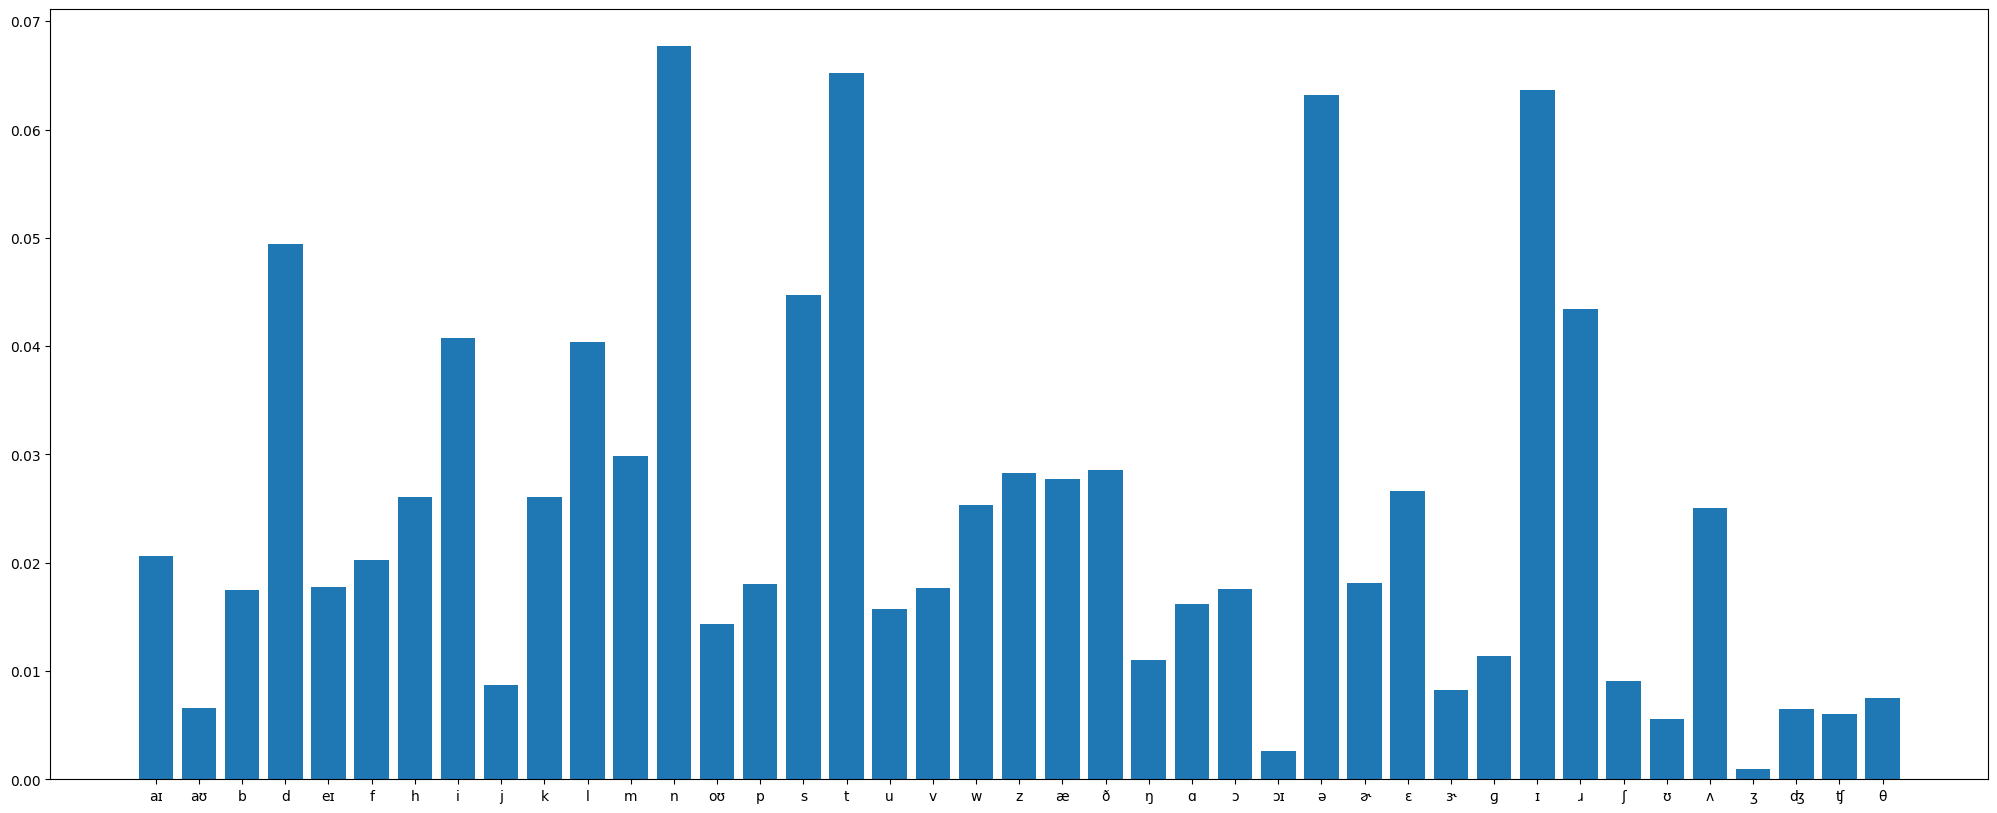

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

plt.bar(phone_vocabs, phone_ratio)

plt.show()

In [20]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(ds)-1)

print("Text:", ds[rand_int]["text"])
print("Phonetics:", ds[rand_int]["phonetic"])
print("Input array shape:", ds[rand_int]["audio"]["array"].shape)
print("Sampling rate:", ds[rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=ds[rand_int]["audio"]["array"], autoplay=False, rate=16000)

Text: i have been doubly baptized
Phonetics: aɪ h æ v b ɪ n d ʌ b l i b æ p t aɪ z d
Input array shape: (38549,)
Sampling rate: 16000


# Build IPA charset vocab

In [24]:
vocab = list(set(phonetics)) + [' ']

In [25]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab))}

print(vocab_dict)

{' ': 0, 'aɪ': 1, 'aʊ': 2, 'b': 3, 'd': 4, 'eɪ': 5, 'f': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'oʊ': 14, 'p': 15, 's': 16, 't': 17, 'u': 18, 'v': 19, 'w': 20, 'z': 21, 'æ': 22, 'ð': 23, 'ŋ': 24, 'ɑ': 25, 'ɔ': 26, 'ɔɪ': 27, 'ə': 28, 'ɚ': 29, 'ɛ': 30, 'ɝ': 31, 'ɡ': 32, 'ɪ': 33, 'ɹ': 34, 'ʃ': 35, 'ʊ': 36, 'ʌ': 37, 'ʒ': 38, 'ʤ': 39, 'ʧ': 40, 'θ': 41}


In [26]:
# make the space more intuitive to understand
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

44

In [27]:
# save vocab.json
import json
with open('/kaggle/working/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

# resample and convert to indices

In [28]:
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor

In [29]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained('/kaggle/working/', unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|", )  # './' load vocab.json in the current directory
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)  
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [30]:
# This does not prepare the input for the Transformer model.
# This will resample the data and convert the sentence into indices
# Batch here is just for one entry (row)
def prepare_dataset(batch):
    audio = batch["audio"]
    
    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["phonetic"]).input_ids
    return batch

In [31]:
ds = ds.map(prepare_dataset)

Map:   0%|          | 0/4402 [00:00<?, ? examples/s]

# Split datasets into folds and save folds

Shuffle first

In [32]:
ds['gender'][-10:]

['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']

In [33]:
shuffled_dataset = ds.shuffle(seed=42)

In [34]:
shuffled_dataset['gender'][-10:]

['F', 'F', 'M', 'F', 'M', 'M', 'M', 'M', 'F', 'M']

okay now we can extract test and val sets for each fold and save the data.

# extract val and test data

In [35]:
# could use LOGO on speaker for LOSO, BUT WILL WE???
from sklearn.model_selection import LeaveOneGroupOut
from collections import defaultdict

In [36]:
def stratified_split_train_dev_per_speaker(ds_train, dev_pct=0.10, seed=42):
    idx_by_spk = defaultdict(list)
    for i, spk in enumerate(ds_train["speaker"]):
        idx_by_spk[spk].append(i)
    rng = np.random.RandomState(seed)
    dev_idx = []                                           # get speaker indices for dev set
    for spk, idxs in idx_by_spk.items():
        n_dev = int(round(dev_pct * len(idxs)))            # how many items in dev set
        sel = rng.choice(idxs, size=n_dev, replace=False)  # random sample of size ndev over idxs
        dev_idx.extend(sel.tolist())                       # add sel choices to end of dev_idx
    dev_idx = sorted(dev_idx)
    train_idx = sorted(set(range(len(ds_train))) - set(dev_idx)) 
    return ds_train.select(train_idx), ds_train.select(dev_idx)

In [37]:
groups = np.array(shuffled_dataset["speaker"])                 # one group(speaker)
indices = np.arange(len(shuffled_dataset))
logo = LeaveOneGroupOut()

In [38]:
for fold_i, (train_idx, test_idx) in enumerate(logo.split(indices, groups=groups), start=1):
    train_pool = shuffled_dataset.select(train_idx)            # all speakers except one
    test_ds    = shuffled_dataset.select(test_idx)             # the held-out speaker (LOSO)
    print("train speakers: ",set(train_pool["speaker"]), " test speakers: ",set(test_ds["speaker"]))

train speakers:  {'MBMPS', 'NJS', 'ERMS'}  test speakers:  {'EBVS'}
train speakers:  {'MBMPS', 'NJS', 'EBVS'}  test speakers:  {'ERMS'}
train speakers:  {'NJS', 'EBVS', 'ERMS'}  test speakers:  {'MBMPS'}
train speakers:  {'MBMPS', 'EBVS', 'ERMS'}  test speakers:  {'NJS'}


# Save dataset

In [41]:
out_root = "/kaggle/working/spanish_loso_es"         # save per-fold dataset dicts here
os.makedirs(out_root, exist_ok=True)
fold_meta = []

for fold_i, (train_idx, test_idx) in enumerate(logo.split(indices, groups=groups), start=1):
    train_pool = shuffled_dataset.select(train_idx)            # all speakers except one
    test_ds    = shuffled_dataset.select(test_idx)             # the held-out speaker (LOSO)

    train_ds, dev_ds = stratified_split_train_dev_per_speaker(train_pool)

    # save DatasetDict for this fold
    dd = DatasetDict({"train": train_ds, "validation": dev_ds, "test": test_ds})
    # Name the fold by the test speaker (readable)
    test_spk = list(set(test_ds["speaker"]))[0]      # LOSO → single speaker in test
    fold_dir = os.path.join(out_root, f"fold_{test_spk}")
    dd.save_to_disk(fold_dir)

    fold_meta.append({"fold": fold_i, 
                      "test_speaker": test_spk,
                      "train_speakers": list(set(train_ds["speaker"])), 
                      "n_dev": len(dev_ds), 
                      "test_speakers": list(set(test_ds["speaker"]))
                     })
    print(f"Saved {fold_dir} →", {k: len(v) for k,v in dd.items()})

# small manifest for reproducibility
with open(os.path.join(out_root, "meta.json"), "w") as f:
    json.dump(fold_meta, f, indent=2)


Saving the dataset (0/3 shards):   0%|          | 0/3056 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/339 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1007 [00:00<?, ? examples/s]

Saved /kaggle/working/spanish_loso_es/fold_EBVS → {'train': 3056, 'validation': 339, 'test': 1007}


Saving the dataset (0/3 shards):   0%|          | 0/2943 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/327 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1132 [00:00<?, ? examples/s]

Saved /kaggle/working/spanish_loso_es/fold_ERMS → {'train': 2943, 'validation': 327, 'test': 1132}


Saving the dataset (0/3 shards):   0%|          | 0/2943 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/327 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1132 [00:00<?, ? examples/s]

Saved /kaggle/working/spanish_loso_es/fold_MBMPS → {'train': 2943, 'validation': 327, 'test': 1132}


Saving the dataset (0/3 shards):   0%|          | 0/2944 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/327 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1131 [00:00<?, ? examples/s]

Saved /kaggle/working/spanish_loso_es/fold_NJS → {'train': 2944, 'validation': 327, 'test': 1131}
